<a href="https://colab.research.google.com/github/AdarshShah/Image-Segmentation/blob/main/Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2
### Adarsh Tushar Shah
### 19473, MTech (A.I.)

In [10]:
import numpy as np
from numpy.linalg import eig
from math import exp

from scipy.sparse.linalg import eigsh

from skimage import img_as_float
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize

from matplotlib import pyplot as plt

from tensorflow.keras.metrics import MeanIoU,mean_squared_error

# 1.0 Ncut

1. The difficulties were faced in calculating the edge weights correctly. The edge weights here are distance based on the spatial and intensity gaussian distribution similar to the bilateral denoising filter equation except for the sum term. The standard deviation tuning was done using the trial and error method. 

2. The second modification done is in the criteria of choosing each pixel's neighbours. The paper suggests to consider pixels within a certain circle i.e. (L2 norm dist(a,b) <= r). Instead L inf norm dist(a,b) <= r is taken with r = 20.

3. The image is resized to 64x64. With this setting, it takes about 10 seconds to run.

In [2]:
def Ncut(image:np.ndarray,radius=20):

  image = rgb2gray(image)
  
  M,N = image.shape

  W = np.zeros(shape=(M*N,M*N))

  for i in range(M):
    for j in range(N):
      for k in range(-radius,radius+1):
        for l in range(-radius,radius+1):
          if i+k>=0 and i+k<M and j+l>=0 and j+l<N:
            a = N*i+j
            b = N*(i+k)+(j+l)
            W[a,b] = exp(-1*(((image[i,j]-image[i+k,j+l])**2)/0.005 + ((k)**2 + (l)**2)/(M*N)**2))


  D = np.diag([np.sum(W[i,:]) for i in range(M*N)])
  D_half = np.diag([1/np.sqrt(np.sum(W[i,:])) for i in range(M*N)])
  A = D_half@(D-W)@D_half
  eig_vals,eig_vectors = eigsh(A,k=2,which='SM')

  y = np.array([D_half[i,i]*eig_vectors[i,1] for i in range(M*N)],dtype=np.float32)
  y = np.signbit(y)

  res_image = np.zeros(image.shape)
  for i in range(M):
    for j in range(N):
      res_image[i,j] = y[N*i+j]
  
  return res_image


## 1.1 Example 1

Please ensure correct data path before running

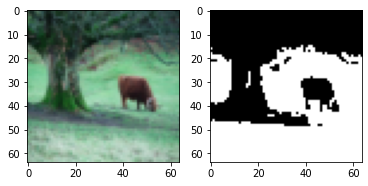

<Figure size 432x288 with 0 Axes>

In [3]:
image = resize(imread('./aip/VOCdevkit/VOC2007/JPEGImages/000013.jpg'),(64,64))
res_image = Ncut(image)
plt.subplot(121)
plt.imshow(image,'brg')
plt.subplot(122)
plt.imshow(res_image,'gray')
plt.show()
plt.clf()

## 1.2 Example 2

Please ensure correct data path before running

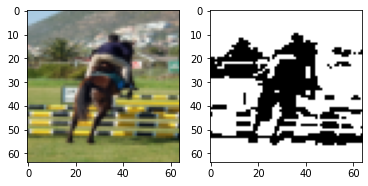

<Figure size 432x288 with 0 Axes>

In [4]:
image = resize(imread('./aip/VOCdevkit/VOC2007/JPEGImages/000010.jpg'),(64,64))
res_image = Ncut(image)
plt.subplot(121)
plt.imshow(image,'brg')
plt.subplot(122)
plt.imshow(res_image,'gray')
plt.show()
plt.clf()

# 2.0 FCN Model

1. The fully connected layers are removed from VGG16
2. The skip architecture is introduced to learn semantic features from deep layers and spatial features from shallow layers.
3. The Conv2DTranspose operator is an upsampling operator which learns itself to be some kind of bilinear interpolator based on training given.
4. The concatenate operator in the model performs the concatenation of deep and shallow layers.
5. The images are resized to 224x224

In [1]:
import tensorflow as tf

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, MaxPooling2D, BatchNormalization, Conv2D, Flatten, AveragePooling2D, Conv2DTranspose, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy,mean_squared_error
from tensorflow.keras.activations import softmax, relu

from skimage.filters import threshold_otsu

import pandas as pd

In [2]:
vgg = VGG16()

In [3]:
vgg.trainable=False

In [97]:
input = Input(shape=(224,224,3))

y = input

for i in range(1,4):
  y = vgg.layers[i](y)

output1 = Conv2DTranspose(1,(2,2),(2,2),activation='relu')(y)

for i in range(4,7):
  y = vgg.layers[i](y)

output2 = Conv2DTranspose(1,(4,4),(4,4),activation='relu')(y)

for i in range(7,11):
  y = vgg.layers[i](y)

output3 = Conv2DTranspose(1,(8,8),(8,8),activation='relu')(y)

for i in range(11,15):
  y = vgg.layers[i](y)

output4 = Conv2DTranspose(1,(16,16),(16,16),activation='relu')(y)

for i in range(15,19):
  y = vgg.layers[i](y)

output5 = Conv2DTranspose(1,(32,32),(32,32),activation='relu')(y)

y = Concatenate(-1)([input,output1,output2,output3,output4,output5])

output = Conv2D(1,(1,1),(1,1),padding='same',activation='sigmoid')(y)

In [98]:
fcn = Model(input,output)

In [99]:
fcn.compile(optimizer=Adam(),loss=mean_squared_error)

In [100]:
fcn.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_13[0][0]']               
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[12][0]']          
                                )                                                          

## 2.1 Data Preparation

1. The Train/Validation/Test Data is obtained from Pascal VOC 2011 dataset.

In [30]:
train_files = pd.read_csv("./aip/TrainVal/VOCdevkit/VOC2011/ImageSets/Segmentation/train.txt")
trainval_files = pd.read_csv("./aip/TrainVal/VOCdevkit/VOC2011/ImageSets/Segmentation/trainval.txt")
val_files = pd.read_csv("./aip/TrainVal/VOCdevkit/VOC2011/ImageSets/Segmentation/val.txt")

In [31]:
filename = train_files['2007_000032'].iloc[np.random.randint(train_files['2007_000032'].count())]

Input Image : RGB 224 x 224 x 3

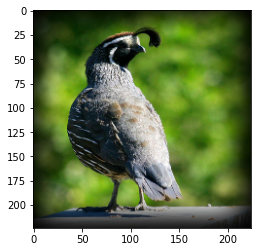

<Figure size 432x288 with 0 Axes>

In [32]:
image = resize(imread(f'./aip/TrainVal/VOCdevkit/VOC2011/JPEGImages/{filename}.jpg'),(224,224))
plt.imshow(image,'brg')
plt.show()
plt.clf()

Output Image : 224x224

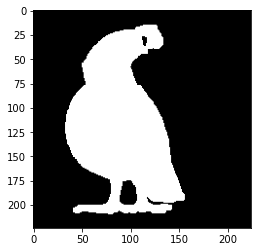

<Figure size 432x288 with 0 Axes>

In [33]:
image = imread(f'./aip/TrainVal/VOCdevkit/VOC2011/SegmentationClass/{filename}.png')
image = resize(image[:,:,0],(224,224))
image = np.where(image>0,1,0)
plt.imshow(image,'gray')
plt.show()
plt.clf()

Train Data Preparation

In [34]:
xtrain = list()
for filename in train_files['2007_000032']:
  image = resize(img_as_float(imread(f'./aip/TrainVal/VOCdevkit/VOC2011/JPEGImages/{filename}.jpg')),(224,224))
  xtrain.append(image)

xtrain = tf.convert_to_tensor(xtrain)

In [35]:
ytrain = list()
for filename in train_files['2007_000032']:
  image = imread(f'./aip/TrainVal/VOCdevkit/VOC2011/SegmentationClass/{filename}.png')
  image = resize(image[:,:,0],(224,224))
  image = np.where(image>0,1,0)
  ytrain.append(image)

ytrain = tf.convert_to_tensor(ytrain)

Validation Data Preparation

In [ ]:
xVal = list()
for filename in trainval_files['2007_000032']:
  image = resize(img_as_float(imread(f'./aip/TrainVal/VOCdevkit/VOC2011/JPEGImages/{filename}.jpg')),(224,224))
  xVal.append(image)

xVal = tf.convert_to_tensor(xVal)

In [ ]:
yVal = list()
for filename in trainval_files['2007_000032']:
  image = imread(f'./aip/TrainVal/VOCdevkit/VOC2011/SegmentationClass/{filename}.png')
  image = resize(image[:,:,0],(224,224))
  image = np.where(image>0,1,0)
  yVal.append(image)

yVal = tf.convert_to_tensor(yVal)

Test Data Preparation

In [ ]:
xtest = list()
for filename in val_files['2007_000033']:
  image = resize(img_as_float(imread(f'./aip/TrainVal/VOCdevkit/VOC2011/JPEGImages/{filename}.jpg')),(224,224))
  xtest.append(image)

xtest = tf.convert_to_tensor(xtest)

In [ ]:
ytest = list()
for filename in val_files['2007_000033']:
  image = imread(f'./aip/TrainVal/VOCdevkit/VOC2011/SegmentationClass/{filename}.png')
  image = resize(image[:,:,0],(224,224))
  image = np.where(image>0,1,0)
  ytest.append(image)

ytest = tf.convert_to_tensor(ytest)

## 2.2 Model Training

In [ ]:
fcn.fit(x=xtrain,y=ytrain,epochs=50,validation_data=(xVal,yVal))

## 2.3 Model Evaluation

1. Randomly generate test cases from test set.

In [138]:
filename = val_files['2007_000033'].iloc[np.random.randint(val_files['2007_000033'].count())]

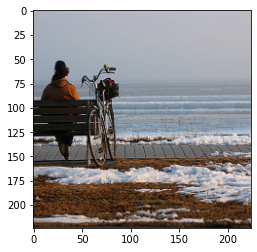

<Figure size 432x288 with 0 Axes>

In [139]:
image = resize(imread(f'./aip/TrainVal/VOCdevkit/VOC2011/JPEGImages/{filename}.jpg'),(224,224))
plt.imshow(image,'brg')
plt.show()
plt.clf()

In [140]:
out = fcn.predict(x=np.reshape(image,(-1,224,224,3)))
out = np.reshape(out,(224,224))

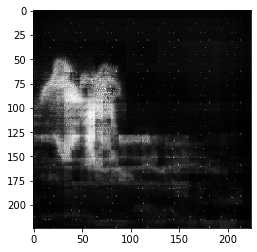

In [141]:
plt.imshow(out,'gray')
plt.show()